In [1]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as pl
import queue
import collections
import seaborn as sns
PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 32                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
recent_frame=0
page_frequency={}
fifo_old_frames={}
mru_recent_frames={}
loc_oldest_frame = np.zeros(F).astype('int32')
phys_mem = np.full((F, 2), INVALID).astype('int32')
algos=["lfu","lru","rr","mru","fifo"]

In [2]:
def init_proc_queue(algo=None):
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        if algo=="fifo":
            fifo_old_frames[pr]=0
        if algo=="mru":
            mru_recent_frames[pr]=0
        pq.put_nowait(pr)
    return(pq)

def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [3]:
def init_phys_mem():
    for i in range(F):
        #         initializing Physical memory to implement FIFO
        phys_mem[i, PID] = INVALID
        phys_mem[i, FRAME] = INVALID


def update_phys_mem(pid):
    for i in range(F):
        #         Updating physical memory of FIFO
        if phys_mem[i, PID] == pid:
            phys_mem[i, PID] = INVALID
            phys_mem[i, FRAME] = INVALID

In [4]:
def correct_refs(alist, cent, maxpg):
    if cent != 0:
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else:
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]):
        if alist[i] >= lh:
            alist[i] = lh - 1
        if alist[i] < ll:
            alist[i] = ll + 1
    return alist
def sim_process(M, sigma, outfile,pid, lfrac=0.9):
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))  # Locality of reference
    sum_refs = 0
    list_locales = list()
    frequencies={}
    for count in range(M):
        frequencies[cur_page]=0
        # random page address in memory.
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random())
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                     num_loc)  # If siagma is less, it stays less within that locality of reference
        # if sigma more, it may vary more
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')
    page_frequency[pid]=frequencies
    return list_locales, sum_refs

In [5]:
def get_oldest_frame(pr):
    global fifo_old_frames
    rv = fifo_old_frames[pr]
    fifo_old_frames[pr] += 1
    if fifo_old_frames[pr] == F:
        fifo_old_frames[pr] = 0
    return rv

    return INVALID
def getFifoFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLruFrame(fr_num, pnum, pr):
    global phys_mem
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            temp = phys_mem[fr_num]
            phys_mem = np.delete(phys_mem, fr_num, axis=0)
            phys_mem = np.concatenate([phys_mem, temp.reshape(1, -1)], axis=0)
            break
        else:
            fr_num += 1
    return fr_num


def getMRUFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            mru_recent_frames[pr]=fr_num
            break
        else:
            fr_num += 1
    return fr_num


def getRRFrame(fr_num, pnum, pr):
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            break
        else:
            fr_num += 1
    return fr_num


def getLFUFrame(fr_num, pnum, pr):
    global page_frequency
    while fr_num < F:
        if phys_mem[fr_num, PID] == pr and phys_mem[fr_num, FRAME] == pnum:
            if pnum not in page_frequency[pr]:
                page_frequency[pr][pnum]=1
            else:
                page_frequency[pr][pnum]+=1
            break
        else:
            fr_num += 1
    return fr_num

In [6]:
def gen_pagefault(pgnum, pr,algo=None):
    global page_frequency
    fr_num = 0
    while fr_num < F and phys_mem[fr_num, FRAME] >= 0:
        fr_num += 1
    if fr_num >= F:
        return INVALID
    phys_mem[fr_num, FRAME] = pgnum
    phys_mem[fr_num, PID] = pr
    if algo=="mru":
        mru_recent_frames[pr]=fr_num
    if algo=="lfu":
        if pgnum not in page_frequency[pr]:
            page_frequency[pr][pgnum]=1
        else:
            page_frequency[pr][pgnum]+=1
    return fr_num

In [7]:
def page_replaceLRU(pgnum, pr):
    global phys_mem
    temp = np.array([pr, pgnum])
    try:
        least_used=np.where(phys_mem[:,0]==pr)[0][0]
    except:
        least_used=0
    phys_mem = np.delete(phys_mem, least_used, axis=0)
    phys_mem = np.concatenate([phys_mem, temp.reshape(1, -1)], axis=0)
    return F-1


def page_replaceFIFO(pgnum, pr):
    cur_frame = get_oldest_frame(pr)
    phys_mem[cur_frame, PID] = pr
    phys_mem[cur_frame, FRAME] = pgnum
    return cur_frame

def page_replaceMRU(pgnum,pr):
    global phys_mem
    temp = np.array([pr, pgnum])
    phys_mem = np.delete(phys_mem, mru_recent_frames[pr], axis=0)
    phys_mem=np.insert(phys_mem,mru_recent_frames[pr],temp,axis=0)
    return mru_recent_frames[pr]


def page_replaceRR(pgnum, pr):
    global phys_mem
    try:
        f_num=np.random.choice(np.where(phys_mem[:,0]==pr)[0])
    except:
        f_num=np.random.randint(F)
    temp = np.array([pr, pgnum])
    phys_mem = np.delete(phys_mem, f_num, axis=0)
    phys_mem=np.insert(phys_mem,f_num,temp,axis=0)
    return f_num

def get_lru_pages(phys_mem,pr,pgnum):
    np.where()

def check_min_freq(page,page_frequency):
    min_freq=min(page_frequency,key=page_frequency.get)
    if min_freq==page:
        return True
    else:
        return False
        
def page_replaceLFU(pgnum,pr):
    global phys_mem
    currentpage=None
    global page_frequency
#     print("Page_frq",page_frequency)
    try:
        process_location=np.where(phys_mem[:,PID]==pr)
#         print("frame",phys_mem)
#         print("Process Location",phys_mem[process_location],pr,pgnum)
        pages=set(phys_mem[process_location][:,FRAME])
#         print("Located Pages",pages)
        current_frequencies={key: page_frequency[pr][key] for key in pages}
#         print("Current_frequencies",current_frequencies)
        for pg in pages:
            min_freq=check_min_freq(pg,current_frequencies)
            if min_freq:
                currentpage=pg
        frame_loc=np.where(phys_mem[process_location][:,FRAME]==currentpage)[0][0]
        temp = np.array([pr,pgnum])
        phys_mem = np.delete(phys_mem, frame_loc, axis=0)
        phys_mem=np.insert(phys_mem,frame_loc,temp,axis=0)
        page_frequency[pr][currentpage]=0
    except:
        dicts={}
        min_el=None
        for j,i in enumerate(phys_mem):
            temp=[]
            pid=i[PID]
            page=i[FRAME]
            if page in page_frequency[pid]:
                if pid not in dicts:
                    if page_frequency[pid][page]==0:
                        pass
                    else:
                        dicts[pid]={page:page_frequency[pid][page],'f_index':j}
                        if len(dicts)==1:
                            min_el=dicts.copy()
                        elif len(dicts)>1:
                            if page_frequency[pid][page]< list(list(min_el.values())[0].values())[0]:
                                min_el={pid:{page:page_frequency[pid][page],'f_index':j}}
                else:
                    if page_frequency[pid][page]<=list(dicts[pid].values())[0] and page_frequency[pid][page]!=0:
                        dicts[pid]={page:page_frequency[pid][page],'f_index':j}
                        if len(dicts)==1:
                            min_el=dicts.copy()
                        elif len(dicts)>1:
                            if page_frequency[pid][page]< list(list(min_el.values())[0].values())[0]:
                                min_el={pid:{page:page_frequency[pid][page],'f_index':j}}
        frame_loc=list(min_el.values())[0]['f_index']
        temp = np.array([pr,pgnum])
        phys_mem = np.delete(phys_mem, frame_loc, axis=0)
        phys_mem=np.insert(phys_mem,frame_loc,temp,axis=0)
        pr=list(min_el.keys())[0]
        pgnum=list(list(min_el.values())[0].keys())[0]
        page_frequency[pr][pgnum]=0
    return frame_loc

#### I used  dict.keys() and dict.values() many places in LFU so as to map and get pages associated to it frequencies and all.

# LeastFreqUsed is divided into two parts. 
1. Geting all the processes that are located in physical memory when page replacement for that particular process
    was called. After that we try to find all the associated pages of particular page and try to find the minimum
    frequency of a page associated to that process. if the page is found with minimum frequency. once the page with 
    minimum frequency is found, we replace that [pid,pgnum] from main memory. if not, it means the physical memory 
    doesnot have current process to replace its associated minimum frequency page.
2. We try to find all other processes and their associated pages which frequency is minimum. once a process and page
    is identified, we replace that with the current pid and page.

In [8]:
def get_pageframe(pnum, pr, algo=None):
    # Trying to get a page Hit below
    fr_num = 0
    if algo == "lru":
        fr_num = getLruFrame(fr_num, pnum, pr)
    elif algo == "fifo":
        fr_num = getFifoFrame(fr_num, pnum, pr)
    elif algo == "mru":
        fr_num = getMRUFrame(fr_num, pnum, pr)
    elif algo == "rr":
        fr_num = getRRFrame(fr_num, pnum, pr)
    elif algo == "lfu":
        fr_num = getLFUFrame(fr_num, pnum, pr)        

    # This indicates Page Hit.
    if fr_num < F:
        return fr_num * PAGE_SIZE, 0

    # This tries to find page fault if occured.
    fr_num = gen_pagefault(pnum, pr,algo)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 1

    # This is for page replacement based on algorith choosen
    if algo == "lru":
        fr_num = page_replaceLRU(pnum, pr)
    elif algo == "fifo":
        fr_num = page_replaceFIFO(pnum, pr)
    elif algo=="rr":
        fr_num=page_replaceRR(pnum,pr)
    elif algo=="mru":
        fr_num=page_replaceMRU(pnum,pr)
    elif algo=="lfu":
        fr_num=page_replaceLFU(pnum,pr)

    if fr_num >= 0:
        return fr_num * PAGE_SIZE, 2
    return INVALID, 0

In [9]:
def mem_manager(infile, outfile, pid, algo=None):
    #    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr:
        addr_ref = infile.readline().strip()
        if addr_ref == '':
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_base, pg_fault = get_pageframe(pg_num, pid, algo)

        if pg_base >= 0:
            phys_addr = pg_base + pg_offset
            outfile.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault) + '\n')  # Saving the logical add, physical add and faults

            if pg_fault == 0:
                pr_timing[pid] += IN_MEMORY
            elif pg_fault == 1:
                pr_timing[pid] += MEM_FAULT
            else:
                pr_timing[pid] += PAGE_REPLACE

        else:
            print(idx)
            return INVALID
        idx += 1

    if idx >= num_addr:
        return INCOMPLETE
    return COMPLETED

In [10]:
def print_phys_mem():
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F):
        if phys_mem[i, PID] != INVALID:
            print('{:^10d} {:^6d} {:^6d}'.format(i, phys_mem[i, PID],
                                                 phys_mem[i, FRAME]))
        else:
            print('Free Frame: ', i)
    print('_____________________________________________________________')


In [11]:
pr_size = np.zeros(NP, dtype='int32')
def create_simulation():
    for p in range(NP):
        fname = 'AR_' + '{:02d}'.format(p) + '.txt'
        op = open(fname, 'w')
        npg = int(np.random.normal(10, 2.5))
        nsig = int(5 * np.random.random())
        print(f'Process {p} requires {npg} pages and has a quality {nsig}')
        pg_seq, pr_size[p] = sim_process(npg, nsig, op,pid=p)
        print(pg_seq, pr_size[p])
        op.write('\n')
        op.close()
        print('Written process ', p, 'to ', fname)

In [12]:
create_simulation()

Process 0 requires 7 pages and has a quality 4
[0, 1, 1, 3, 0, 5, 5] 15969
Written process  0 to  AR_00.txt
Process 1 requires 13 pages and has a quality 1
[5, 6, 6, 8, 12, 8, 10, 9, 10, 8, 5, 6, 10] 32249
Written process  1 to  AR_01.txt
Process 2 requires 9 pages and has a quality 2
[8, 1, 4, 6, 3, 5, 8, 7, 4] 23352
Written process  2 to  AR_02.txt
Process 3 requires 10 pages and has a quality 2
[6, 5, 4, 1, 5, 1, 7, 7, 2, 0] 26596
Written process  3 to  AR_03.txt
Process 4 requires 10 pages and has a quality 2
[1, 7, 6, 2, 6, 5, 7, 6, 7, 0] 17968
Written process  4 to  AR_04.txt
Process 5 requires 6 pages and has a quality 4
[0, 2, 2, 1, 3, 3] 12620
Written process  5 to  AR_05.txt


In [13]:
for algo in algos:
    print(f"_________________________Algorithm {algo}______________________________\n")
    phys_mem = np.full((F, 2), INVALID).astype('int32')
#     fifo_old_frames={}
#     mru_recent_frames={}
    init_phys_mem()
#     oldest_frame = 0
#     recent_frame=0
    pr_que = init_proc_queue(algo)
    pr_timing = np.zeros(F).astype('int32')
    IN_MEMORY = 1
    MEM_FAULT = 50
    PAGE_REPLACE = 100

    # Open necessary files
    infiles = list()
    outfiles = list()
    for i in range(NP):
        fname = 'AR_{:02d}.txt'.format(i)
        outname = 'AR_{:02}_{}_out.txt'.format(i, algo)

        if os.access(fname, os.R_OK):
            print(f'Reading Process from {fname}')
            infiles.append(open(fname, 'r'))
        else:
            print(f'Cannot open {fname} for reading')
        outfiles.append(open(outname, 'w'))

    # Map logical into physical addresses and keep track of page faults
    for pr in readq(pr_que):
        rv = mem_manager(infiles[pr], outfiles[pr], pr, algo=algo)
        if rv == INVALID:
            print('Memory overflow error')
            break
        if rv == INCOMPLETE:
            pr_que.put_nowait(pr)
        else:
#             print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
#             removing from queue')
#             print(f'Time taken: {pr_timing[pr]}')
            slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
            print('Slow down by {:.2f}%'.format(slow))
            print_phys_mem()
            update_phys_mem(pr)

    #        print('Current Status of Physical Memory')
    #        print_phys_mem()

    # Close all files
    for i in range(NP):
        infiles[i].close()
        outfiles[i].close()

_________________________Algorithm lfu______________________________

[4, 2, 1, 0, 5, 3]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt
Slow down by 1.94%
  Frame     PID   Page No.
  -----     ---   --------
    0        5      3   
    1        0      3   
    2        0      4   
    3        0      2   
    4        1      12  
    5        1      5   
    6        1      9   
    7        1      7   
    8        1      10  
    9        1      11  
    10       0      0   
    11       0      1   
    12       5      0   
    13       5      2   
    14       5      1   
    15       3      6   
    16       3      3   
    17       3      5   
    18       3      4   
    19       3      2   
    20       3      0   
    21       3      1   
    22       2      0   
    23       2      1   
    24       1      3   
    25       1      1   
  

Slow down by 16.36%
  Frame     PID   Page No.
  -----     ---   --------
    0        1      11  
Free Frame:  1
Free Frame:  2
    3        1      12  
    4        1      4   
    5        1      8   
    6        1      0   
    7        1      9   
    8        1      7   
    9        1      5   
    10       1      3   
    11       1      1   
    12       1      2   
    13       1      6   
    14       1      10  
    15       2      8   
    16       2      1   
    17       2      3   
    18       2      5   
    19       2      6   
    20       2      2   
    21       2      0   
    22       2      4   
    23       2      7   
    24       3      7   
    25       3      5   
    26       3      6   
    27       3      3   
    28       3      4   
    29       3      0   
    30       3      1   
    31       3      2   
_____________________________________________________________
Slow down by 20.54%
  Frame     PID   Page No.
  -----     ---   --------
    0     

Slow down by 117.26%
  Frame     PID   Page No.
  -----     ---   --------
    0        1      5   
    1        3      1   
    2        4      1   
    3        4      2   
    4        4      0   
    5        4      4   
    6        4      6   
    7        4      5   
    8        4      7   
    9        4      3   
    10       2      1   
    11       0      5   
    12       0      4   
    13       5      3   
    14       5      1   
    15       5      2   
    16       3      3   
    17       3      0   
    18       3      6   
    19       3      7   
    20       3      4   
    21       3      2   
    22       1      3   
    23       1      1   
    24       1      0   
    25       1      4   
    26       1      2   
    27       1      6   
    28       2      3   
    29       2      6   
    30       2      8   
    31       2      2   
_____________________________________________________________
Slow down by 20.83%
  Frame     PID   Page No.
  -----     --- 

Slow down by 3.59%
  Frame     PID   Page No.
  -----     ---   --------
    0        1      7   
    1        2      4   
    2        2      6   
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free Frame:  6
Free Frame:  7
    8        1      10  
    9        2      2   
    10       2      5   
Free Frame:  11
    12       2      7   
Free Frame:  13
Free Frame:  14
Free Frame:  15
Free Frame:  16
    17       2      8   
    18       1      8   
    19       1      9   
Free Frame:  20
    21       1      5   
    22       1      3   
    23       1      1   
    24       1      0   
    25       1      4   
    26       1      2   
    27       1      6   
Free Frame:  28
    29       2      3   
    30       2      0   
    31       2      1   
_____________________________________________________________
Slow down by 4.28%
  Frame     PID   Page No.
  -----     ---   --------
    0        1      7   
Free Frame:  1
Free Frame:  2
Free Frame:  3
Free Frame:  4
Free Frame:  5
Free 

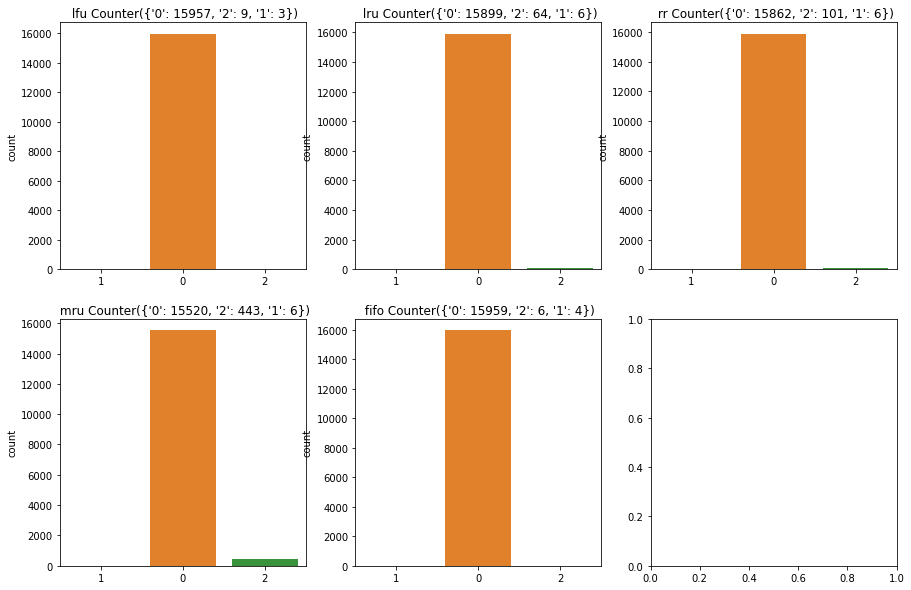

In [14]:
fig,axes=pl.subplots(2,3,figsize=(15,10))
axes=axes.ravel()[:5]
for algo,axs in zip(algos,axes):
    file_name='AR_00_{}_out.txt'.format(algo)
    file=open(file_name,'r')
    data=file.read()
    datas=np.array(data.split('\n'))
    faults=[data[-1] for data in datas[:-1]]
    sns.countplot(x=faults,ax=axs)
    axs.set_title(" {} {}".format(algo,collections.Counter(faults)))